%%html
<style>
#notebook-container {width: 100%;}
.code_cell {flex-direction: row !important;}
.code_cell .output_wrapper {width: 50%;left: 0px;}
.code_cell .input {width: 50%;}
</style>

In [118]:
cd ..

/private/home/jeanremi/project/jrr/code


In [122]:
cd meg_experiment/

/private/home/jeanremi/project/jrr/code/meg_experiment


In [129]:
from base import B2B, CrossDecomp, Forward
from sklearn.cross_decomposition import CCA

In [124]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import scale
from scipy.stats import norm, pearsonr
from scipy.linalg import pinv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
%matplotlib inline

In [26]:
from scipy.linalg import svd
from scipy.stats import pearsonr
from sklearn.preprocessing import scale

def ridge_cv(X, Y, alphas, independent_alphas=False, Uv=None):
    """ Similar to sklearn RidgeCV but
   (1) can optimize a different alpha for each column of Y
   (2) return leave-one-out Y_hat
   """
    if isinstance(alphas, (float, int)):
        alphas = np.array([alphas, ], np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, n_x = X.shape
    n, n_y = Y.shape
    # Decompose X
    if Uv is None:
        U, s, _ = svd(X, full_matrices=0)
        v = s**2
    else:
        U, v = Uv
    UY = U.T @ Y

    # For each alpha, solve leave-one-out error coefs
    cv_duals = np.zeros((len(alphas), n, n_y))
    cv_errors = np.zeros((len(alphas), n, n_y))
    for alpha_idx, alpha in enumerate(alphas):
        # Solve
        w = ((v + alpha) ** -1) - alpha ** -1
        c = U @ np.diag(w) @ UY + alpha ** -1 * Y
        cv_duals[alpha_idx] = c

        # compute diagonal of the matrix: dot(Q, dot(diag(v_prime), Q^T))
        G_diag = (w * U ** 2).sum(axis=-1) + alpha ** -1
        error = c / G_diag[:, np.newaxis]
        cv_errors[alpha_idx] = error

    # identify best alpha for each column of Y independently
    if independent_alphas:
        best_alphas = (cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = np.transpose([cv_duals[b, :, i]
                              for i, b in enumerate(best_alphas)])
        cv_errors = np.transpose([cv_errors[b, :, i]
                                  for i, b in enumerate(best_alphas)])
    else:
        _cv_errors = cv_errors.reshape(len(alphas), -1)
        best_alphas = (_cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = cv_duals[best_alphas]
        cv_errors = cv_errors[best_alphas]

    coefs = duals.T @ X
    Y_hat = Y - cv_errors
    return coefs, best_alphas, Y_hat


def fit_knockout(X, Y, alphas, knockout=True, independent_alphas=False,
                 pairwise=False):
    """Fit model using all but knockout X features"""
    if Y.ndim == 1:
        Y = Y[:, None]
    n_x, n_y = X.shape[1], Y.shape[1]
    knockout = np.arange(n_x)[:, None] if knockout is True else knockout

    K = list()
    for xi in knockout:
        not_xi = np.setdiff1d(np.arange(n_x), xi)

        # When X and Y are matched in dimension, we can speed things
        # up by only computing the regression pairwise, as the other
        # columns won't be analyzed
        if pairwise:
            y_sel = np.asarray(xi)
        else:
            y_sel = np.arange(Y.shape[1])
        x_sel = np.array(not_xi)

        K_ = np.zeros((n_y, n_x))
        K_[y_sel[:, None], x_sel] = ridge_cv(X[:, x_sel], Y[:, y_sel],
                                             alphas, independent_alphas)[0]
        K.append(K_)
    return K


def r_score(Y_true, Y_pred):
    """column-wise correlation coefficients"""
    if Y_true.ndim == 1:
        Y_true = Y_true[:, None]
    if Y_pred.ndim == 1:
        Y_pred = Y_pred[:, None]
    R = np.zeros(Y_true.shape[1])
    for idx, (y_true, y_pred) in enumerate(zip(Y_true.T, Y_pred.T)):
        R[idx] = pearsonr(y_true, y_pred)[0]
    return R


class B2B():
    def __init__(self, alphas=np.logspace(-4, 4, 20),
                 independent_alphas=True,
                 knockout=True):
        self.alphas = alphas
        self.knockout = knockout
        self.independent_alphas = independent_alphas

    def fit(self, X, Y):
        # Fit decoder
        self.G_, G_alpha, YG = ridge_cv(
            Y, X, self.alphas, self.independent_alphas)
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(X, YG, self.alphas,
                                       self.independent_alphas)
        # Fit knock-out encoders
        if self.knockout:
            self.Ks_ = fit_knockout(X, YG, self.alphas,
                                    self.knockout,
                                    self.independent_alphas, True)

        return self

    def score(self, X, Y):
        # Transform with decoder
        YG = Y @ self.G_.T
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column X
        return r_score(YG, XH)

    def score_knockout(self, X, Y):
        # Transform with decoder
        YG = Y @ self.G_.T
        # Allow knocking out blocks of features
        if self.knockout is True:
            knockout = range(X.shape[1])
        else:
            knockout = self.knockout

        # For each knock-out, compute R score
        K_scores = list()
        for xi, K in zip(knockout, self.Ks_):
            # Knocked-out encoder predictions
            XK = X @ K.T
            # R score for each relevant dimensions of X
            r = r_score(YG[:, xi], XK[:, xi])
            # If one dimension, make it float
            if isinstance(xi, int):
                r = r[0]
            # Difference between standard and knocked-out scores
            K_scores.append(r)

        return np.array(K_scores)


class Forward():
    def __init__(self, alphas=np.logspace(-4, 4, 20), independent_alphas=True,
                 knockout=True):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.knockout = knockout

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(X, Y, self.alphas,
                                       self.independent_alphas)
        # Fit knock-out encoders
        if self.knockout:
            self.Ks_ = fit_knockout(X, Y, self.alphas,
                                    self.knockout,
                                    self.independent_alphas, False)

        return self

    def score(self, X, Y):
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column of Y
        return r_score(Y, XH)

    def score_knockout(self, X, Y):
        if self.knockout is True:
            knockout = range(X.shape[1])
        else:
            knockout = self.knockout

        R = list()
        for xi, K in zip(knockout, self.Ks_):
            # Knocked-out encoder predictions
            XK = X @ K.T
            # R score for each relevant dimensions of X
            K_score = r_score(Y, XK)
            # Difference between standard and knocked-out scores
            R.append(K_score)

        return np.array(R)


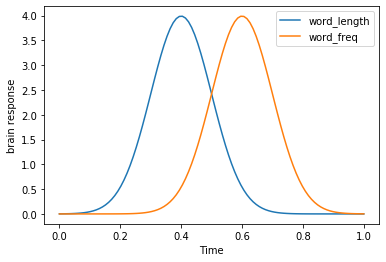

In [125]:
# Many neuroimaging study consist in identifying which factor cause brain activity.
# For example, some primary visual regions may respond proportionally to the size
# of a word (i.e. a low-level feature), whereas secondary areas may respond
# proportionnally to their frequency (i.e. a semantic, and thus high-level feature)
n_times = 100
time = np.linspace(0, 1, n_times)
word_length = norm.pdf(time, .4, .1)
word_freq = norm.pdf(time, .6, .1)
plt.plot(time, word_length, label='word_length')
plt.plot(time, word_freq, label='word_freq')
plt.xlabel('Time')
plt.ylabel('brain response')
plt.legend()

In [126]:
# Simulate 1000 brain responses to distinct words
Z = np.c_[word_length, word_freq].T  # typical dynamics of effects
n = 1000  # number of words
Cx = np.array([[1, -.8], [-.8, 1.]])  # feature covariance
X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
Y = X @ Z  # brain response
Y += np.random.randn(*Y.shape)  # add noise


In [127]:
def make_data(snr=1.):
    n = 1000  # number of words
    Cx = np.array([[1, -.8], [-.8, 1.]])  # feature covariance
    X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
    X = scale(X)
    
    F = np.array([[1., .5], [-.5, 1.]])  # forward: from source to sensor
    dy = 3
    F = np.random.randn(dy, dy)
    Y = np.zeros((n, dy, n_times))
    for t, (length, freq) in enumerate(zip(word_length, word_freq)):
        Z = np.diag([length, freq])
        source = X @ Z
        # add source noise
        noise = np.random.randn(n) / (snr + 1e-7)
        source = np.c_[source, noise]
        # Y is now our multivariate measurement (i.e. sensors)
        Y[:, :, t] = source @ F
        Y[:, :, t] += np.random.randn(n, dy)  # add sensor noise
        Y[:, :, t] = scale(Y[:, :, t])

    return X, Y

In [ ]:
X, Ys = make_data(1e-4)
#Ys += np.random.randn(*Ys.shape)/100

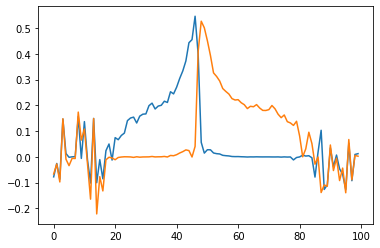

In [155]:
train = range(0, len(X), 2)
test = range(1, len(X), 2)

model = B2B(ensemble=20)
scores = list()
for t in range(n_times):
    Y = Ys[:, :, t]
    model.fit(X[train], Y[train])
    r = model.score(X[test], Y[test])
    rko = model.score_knockout(X[test], Y[test])
    scores.append(np.squeeze(r - rko))
plt.plot(scores)

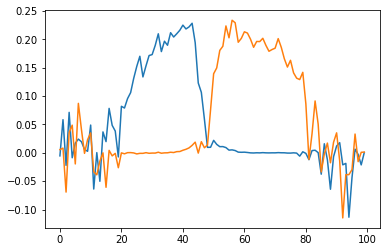

In [156]:
train = range(0, len(X), 2)
test = range(1, len(X), 2)

model = CrossDecomp(CCA(1))
scores = list()
H = list()
for t in range(n_times):
    Y = Ys[:, :, t]
    model.fit(X[train], Y[train])
    r = model.score(X[test], Y[test])
    rko = model.score_knockout(X[test], Y[test])
    H.append(model.model_.x_scores_)
    scores.append(np.squeeze(r - rko))

plt.plot(np.array(scores)[:, 0], color='C0')
plt.plot(np.array(scores)[:, 1], color='C1')

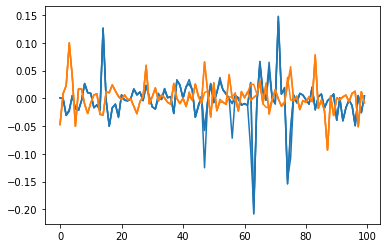

In [147]:
model = Forward()
scores = list()
for t in range(n_times):
    Y = Ys[:, :, t]
    model.fit(X[train], Y[train])
    r = model.score(X[test], Y[test])
    rko = model.score_knockout(X[test], Y[test])
    scores.append(np.squeeze(r - rko))
plt.plot(np.array(scores)[:, 0], color='C0')
plt.plot(np.array(scores)[:, 1], color='C1')

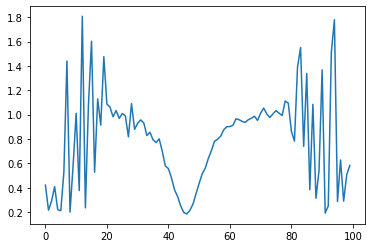

In [145]:
plt.plot(np.nanmean(np.squeeze(H)**2,1))

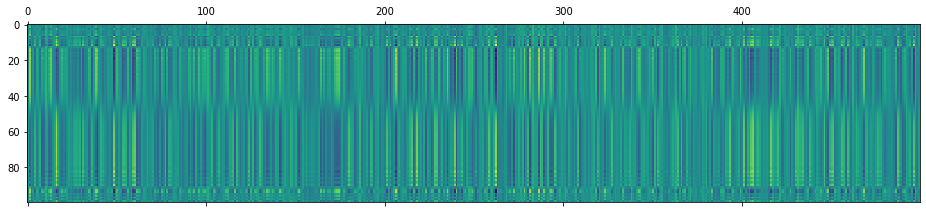

In [139]:
def make_data(snr=1., dx=10, dy=10):
    n = 1000  # number of words
    Cx = np.random.randn(dx, dx)  # feature covariance
    Cx = Cx @ Cx.T
    X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
    X = scale(X)
    w
    F = np.random.randn(dx, dy)
    Y = np.zeros((n, dy, n_times))
    for t, (length, freq) in enumerate(zip(word_length, word_freq)):
        Z = np.diag([length, freq])
        source = X @ Z
        # add source noise
        noise = np.random.randn(n) / (snr + 1e-7)
        source = np.c_[source, noise]
        # Y is now our multivariate measurement (i.e. sensors)
        Y[:, :, t] = source @ F
        Y[:, :, t] += np.random.randn(n, dy)  # add sensor noise
        Y[:, :, t] = scale(Y[:, :, t])

    return X, Y